# MMDETECTION-训练

liangyu 20230607

In [36]:
import torch
print(torch.__version__)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.10.1+cu113


In [37]:
# # 安装Pytorch
#!pip3 install install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio==0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [39]:
pwd

'/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation'

In [40]:
# 进入主目录
import os
# os.chdir('mmsegmentation')

In [41]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip

--2023-06-15 17:02:32--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13230222 (13M) [application/zip]
Saving to: ‘Watermelon87_Semantic_Seg_Mask.zip’

Watermelon87_Semant 100%[===================>]  12.62M  28.1MB/s    in 0.4s    

2023-06-15 17:02:32 (28.1 MB/s) - ‘Watermelon87_Semantic_Seg_Mask.zip’ saved [13230222/13230222]



In [31]:
# 解压
!unzip Watermelon87_Semantic_Seg_Mask.zip

Archive:  Watermelon87_Semantic_Seg_Mask.zip
replace Watermelon87_Semantic_Seg_Mask/img_dir/train/IMG_6865-1024x683.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [32]:
# 删除压缩包
!rm -rf Watermelon87_Semantic_Seg_Mask.zip

In [33]:
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# 指定单张图像路径
img_path = 'Watermelon87_Semantic_Seg_Mask/img_dir/train/20170613134012_430390.jpg'
mask_path = 'Watermelon87_Semantic_Seg_Mask/ann_dir/train/20170613134012_430390.png'

In [36]:
!pwd

/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation


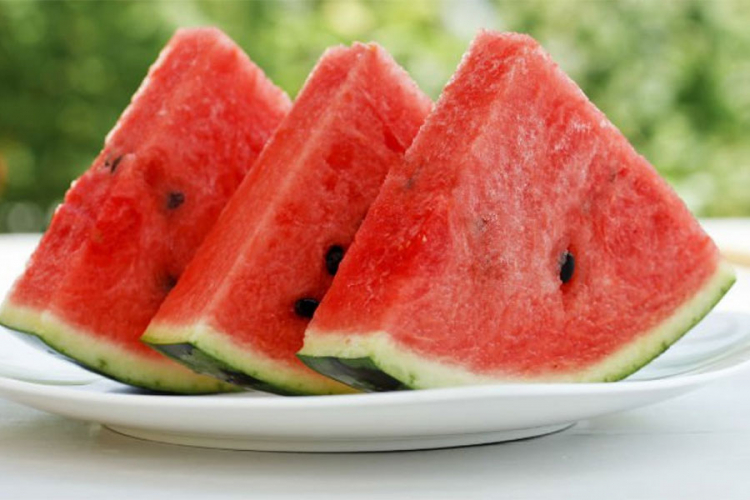

In [37]:
Image.open(img_path)

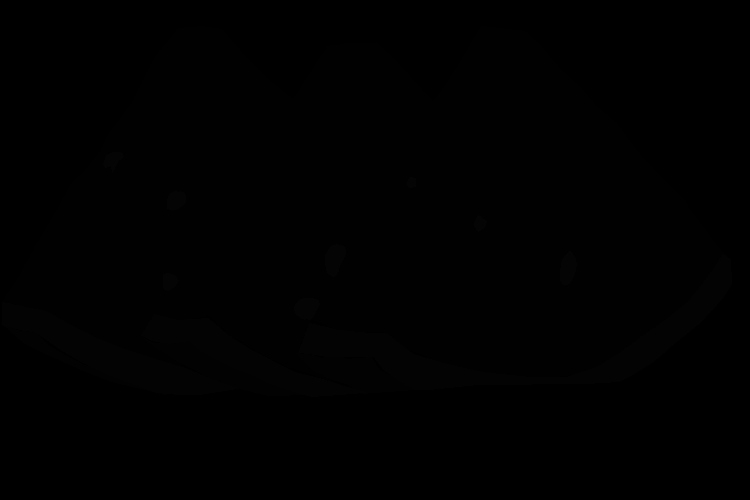

In [38]:

Image.open(mask_path)



In [39]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [40]:
# mask 语义分割标注，与原图大小相同
np.unique(mask)

array([0, 1, 2, 3, 4], dtype=uint8)

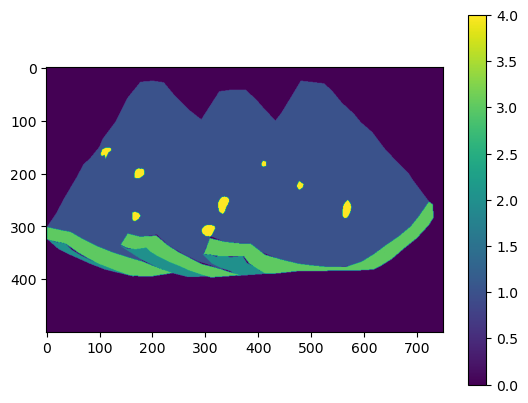

In [41]:
# 可视化语义分割标注
plt.imshow(mask[:,:,2])
plt.colorbar()
plt.show()

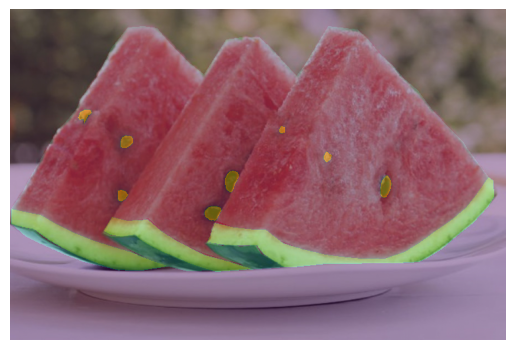

In [42]:
plt.imshow(img[:,:,::-1])
plt.imshow(mask[:,:,0], alpha=0.4) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

# 1. 批量注释 mask

In [43]:
# 指定图像和标注路径
PATH_IMAGE = 'Watermelon87_Semantic_Seg_Mask//img_dir/train'
PATH_MASKS = 'Watermelon87_Semantic_Seg_Mask//ann_dir/train'

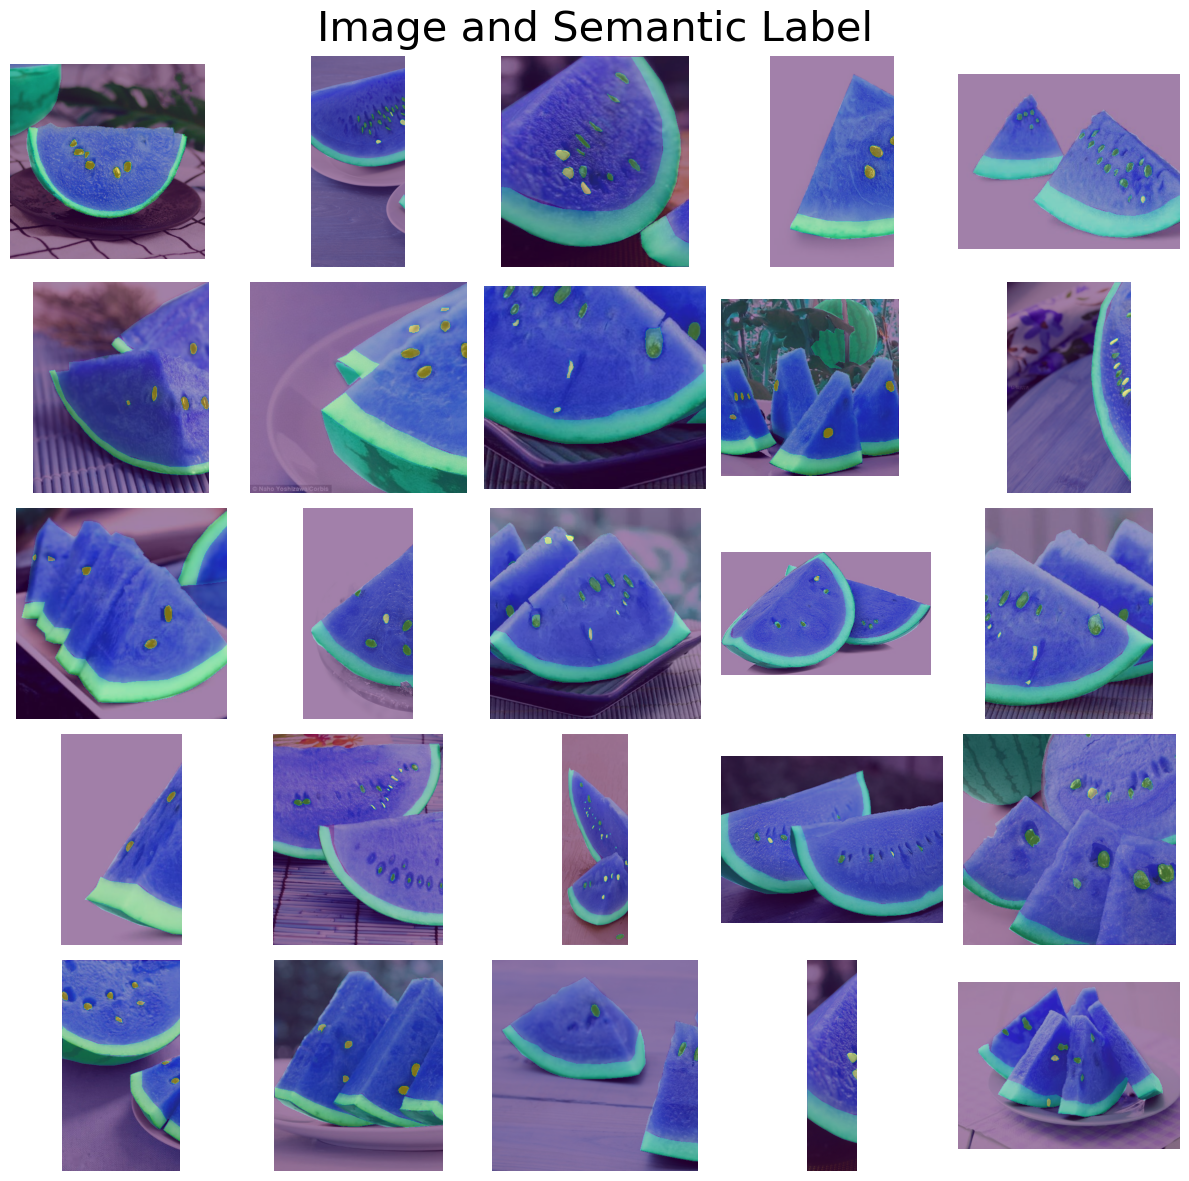

In [44]:
# n行n列可视化
n = 5

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask[:,:,0], alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

In [45]:
!pwd

/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation


In [46]:
# 从 Model Zoo 获取 PSPNet 预训练模型，下载并保存在 checkpoint 文件夹中
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoint
# 伦敦街景图片
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220713-mmdetection/images/street_uk.jpeg -P data

# 上海驾车街景视频，视频来源：https://www.youtube.com/watch?v=ll8TgCZ0plk
!wget https://zihao-download.obs.cn-east-3.myhuaweicloud.com/detectron2/traffic.mp4 -P data

# 街拍视频，2022年3月30日
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220713-mmdetection/images/street_20220330_174028.mp4 -P data


--2023-06-15 19:39:57--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 159.226.227.114, 159.226.227.110, 159.226.227.115, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|159.226.227.114|:443... failed: Connection timed out.
Connecting to download.openmmlab.com (download.openmmlab.com)|159.226.227.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.1’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  12.6MB/s    in 16s     

2023-06-15 19:42:23 (11.9 MB/s) - ‘checkpoint/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.1’ saved [196205945/196205945]

--2023-06-15 19:42:23--  https://zihao-openmmlab.obs.cn-east-3.m

In [47]:
# 2.config

In [48]:
!rm -rf mmseg/datasets/DubaiDataset.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py -P mmseg/datasets

--2023-06-15 19:42:25--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 867 [binary/octet-stream]
Saving to: ‘mmseg/datasets/DubaiDataset.py’

DubaiDataset.py     100%[===================>]     867  --.-KB/s    in 0s      

2023-06-15 19:42:25 (117 MB/s) - ‘mmseg/datasets/DubaiDataset.py’ saved [867/867]



In [49]:
!rm -rf mmseg/datasets/__init__.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py -P mmseg/datasets

--2023-06-15 19:42:26--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2620 (2.6K) [binary/octet-stream]
Saving to: ‘mmseg/datasets/__init__.py’

__init__.py         100%[===================>]   2.56K  --.-KB/s    in 0s      

2023-06-15 19:42:26 (12.2 MB/s) - ‘mmseg/datasets/__init__.py’ saved [2620/2620]



In [50]:
!rm -rf configs/_base_/datasets/DubaiDataset_pipeline.py
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset_pipeline.py -P configs/_base_/datasets

--2023-06-15 19:42:27--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset_pipeline.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2268 (2.2K) [binary/octet-stream]
Saving to: ‘configs/_base_/datasets/DubaiDataset_pipeline.py’

DubaiDataset_pipeli 100%[===================>]   2.21K  --.-KB/s    in 0s      

2023-06-15 19:42:27 (22.7 MB/s) - ‘configs/_base_/datasets/DubaiDataset_pipeline.py’ saved [2268/2268]



In [51]:
!rm -rf configs/pspnet/pspnet_r50-d8_4xb2-40k_DubaiDataset.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/pspnet_r50-d8_4xb2-40k_DubaiDataset.py -P configs/pspnet 

--2023-06-15 19:42:27--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/pspnet_r50-d8_4xb2-40k_DubaiDataset.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344 [binary/octet-stream]
Saving to: ‘configs/pspnet/pspnet_r50-d8_4xb2-40k_DubaiDataset.py’

pspnet_r50-d8_4xb2- 100%[===================>]     344  --.-KB/s    in 0s      

2023-06-15 19:42:27 (49.9 MB/s) - ‘configs/pspnet/pspnet_r50-d8_4xb2-40k_DubaiDataset.py’ saved [344/344]



In [67]:
from mmengine import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r50-d8_4xb2-40k_DubaiDataset.py')

In [68]:
# modify config

In [69]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/DubaiDataset'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [63]:
# save cfg
cfg.dump('Watermelon87_Semantic_Seg_Mask/pspnet-watermelon.py')

In [4]:
import os
!pwd
os.chdir('mmsegmentation')
!pwd

/home/liangyu/code/mmlab2/2023AI/0612
/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation


# train

In [11]:
!python tools/train.py Watermelon87_Semantic_Seg_Mask/pspnet-watermelon.py

06/15 23:26:02 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) [GCC 11.3.0]
    CUDA available: False
    numpy_random_seed: 0
    GCC: gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fop

# 训练完成，开始测试：

In [2]:
!pwd
import os
os.chdir('mmsegmentation')
!pwd

/home/liangyu/code/mmlab2/2023AI/0612
/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation


In [3]:
!python tools/test.py Watermelon87_Semantic_Seg_Mask/pspnet-watermelon.py work_dirs/DubaiDataset/iter_3000.pth

06/16 09:32:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) [GCC 11.3.0]
    CUDA available: False
    numpy_random_seed: 0
    GCC: gcc (Ubuntu 12.2.0-3ubuntu1) 12.2.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.3, CUDNN_VERSION=8.2.0, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fop

In [2]:
!pwd
import os
os.chdir('mmsegmentation')
!pwd

/home/liangyu/code/mmlab2/2023AI/0612
/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation


In [4]:
os.listdir('Watermelon87_Semantic_Seg_Mask/test_dir')

['OIP-C.jpeg', 'test.mp4']

In [7]:
!python demo/image_demo.py \
        Watermelon87_Semantic_Seg_Mask/test_dir/OIP-C.jpeg \
        Watermelon87_Semantic_Seg_Mask/pspnet-watermelon.py \
        work_dirs/DubaiDataset/iter_3000.pth \
        --out-file work_dirs/outputs/outputs.jpg \
        --device cpu \
        --opacity 0.7

/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: work_dirs/DubaiDataset/iter_3000.pth
06/16 11:38:55 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


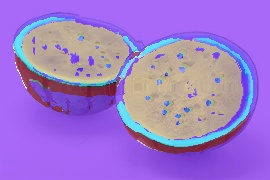

In [8]:
from PIL import Image
Image.open('work_dirs/outputs/outputs.jpg')

In [11]:
!python demo/video_demo.py \
        Watermelon87_Semantic_Seg_Mask/test_dir/test.mp4 \
        Watermelon87_Semantic_Seg_Mask/pspnet-watermelon.py \
        work_dirs/DubaiDataset/iter_3000.pth \
        --output-file work_dirs/outputs/outputs.mp4 \
        --device cpu \
        --opacity 0.7

/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/liangyu/code/mmlab2/2023AI/0612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: work_dirs/DubaiDataset/iter_3000.pth
OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
06/16 12:33:57 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
